In [2]:

import os
!kaggle
!chmod 600 ./kaggle.json
os.environ['KAGGLE_CONFIG_DIR'] = '.'


usage: kaggle [-h] [-v] [-W]
              {competitions,c,datasets,d,kernels,k,models,m,files,f,config}
              ...
kaggle: error: the following arguments are required: command


In [3]:
!kaggle competitions download -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 1.09GB/s]


In [4]:
!unzip udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip

Archive:  udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip
  inflating: submission_example.csv  
  inflating: test.csv                
  inflating: train.csv               


El paradigma a seguir es supervised learning

In [5]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 7.8 MB/s eta 0:00:00


In [7]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import warnings
warnings.filterwarnings('ignore')


def cargar_datos_preprocesados():
        df = pd.read_csv('train.csv')  # O el archivo que tengas
        print(f"Datos cargados: {df.shape}")
        return df

# Cargar datos
df = cargar_datos_preprocesados()
TARGET_COL = 'RENDIMIENTO_GLOBAL'
ID_COL = 'ID'

print(f"Columnas en el dataset: {list(df.columns)}")
print(f"Tipos de datos originales:")
print(df.dtypes.value_counts())
if TARGET_COL in df.columns:
    print(f"\nDistribución de la variable objetivo ({TARGET_COL}):")
    target_counts = df[TARGET_COL].value_counts().sort_index()
    print(target_counts)

    # Visualizar distribución del target
    fig = px.bar(x=target_counts.index, y=target_counts.values,
                 title=f'Distribución de la Variable Objetivo: {TARGET_COL}',
                 labels={'x': TARGET_COL, 'y': 'Frecuencia'},
                 color=target_counts.values,
                 color_continuous_scale='viridis')
    fig.show()


Datos cargados: (692500, 21)
Columnas en el dataset: ['ID', 'PERIODO', 'ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO', 'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA', 'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET', 'FAMI_EDUCACIONPADRE', 'FAMI_TIENELAVADORA', 'FAMI_TIENEAUTOMOVIL', 'ESTU_PRIVADO_LIBERTAD', 'ESTU_PAGOMATRICULAPROPIO', 'FAMI_TIENECOMPUTADOR', 'FAMI_TIENEINTERNET.1', 'FAMI_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL', 'coef_1', 'coef_2', 'coef_3', 'coef_4']
Tipos de datos originales:
object     15
float64     4
int64       2
Name: count, dtype: int64

Distribución de la variable objetivo (RENDIMIENTO_GLOBAL):
RENDIMIENTO_GLOBAL
alto          175619
bajo          172987
medio-alto    171619
medio-bajo    172275
Name: count, dtype: int64


In [8]:

# ===================================================================
# IDENTIFICAR TIPOS DE COLUMNAS PARA CONVERSIÓN
# ===================================================================

def identificar_columnas_para_conversion(df, target_col='RENDIMIENTO_GLOBAL', id_col='ID'):
    """
    Identifica qué tipo de conversión necesita cada columna.
    """
    print(f"\n=== IDENTIFICANDO TIPOS DE COLUMNAS PARA CONVERSIÓN ===")

    # Columnas a excluir
    excluir = [target_col, id_col] if id_col in df.columns else [target_col]

    tipos_conversion = {
        'numericas': [],           # Ya están en formato correcto
        'ordinales': [],           # Necesitan LabelEncoder con orden específico
        'binarias': [],           # Necesitan mapeo simple 0/1
        'nominales_pocas': [],    # OneHotEncoder (≤ 10 categorías)
        'nominales_muchas': [],   # LabelEncoder simple (> 10 categorías)
        'texto': [],              # TF-IDF o CountVectorizer
        'excluir': excluir        # No procesar
    }

    for col in df.columns:
        if col in excluir:
            continue

        # Si ya es numérica, mantener
        if pd.api.types.is_numeric_dtype(df[col]):
            tipos_conversion['numericas'].append(col)
            continue

        # Contar valores únicos
        valores_unicos = df[col].nunique()
        muestra_valores = df[col].dropna().unique()[:5]  # Primeros 5 valores para inspección

        print(f"\nColumna: {col}")
        print(f"  Valores únicos: {valores_unicos}")
        print(f"  Muestra: {muestra_valores}")

        # Decidir tipo de conversión
        if valores_unicos == 2:
            tipos_conversion['binarias'].append(col)
            print(f"  → BINARIA")

        elif any(keyword in ' '.join(str(v).lower() for v in muestra_valores)
                for keyword in ['estrato', 'primaria', 'bachillerato', 'universitaria', 'postgrado', 'bajo', 'medio', 'alto']):
            tipos_conversion['ordinales'].append(col)
            print(f"  → ORDINAL")

        elif valores_unicos <= 10:
            tipos_conversion['nominales_pocas'].append(col)
            print(f"  → NOMINAL (OneHot)")

        elif valores_unicos <= 50:
            tipos_conversion['nominales_muchas'].append(col)
            print(f"  → NOMINAL (Label)")

        else:
            tipos_conversion['texto'].append(col)
            print(f"  → TEXTO (TF-IDF)")

    return tipos_conversion

tipos_conversion = identificar_columnas_para_conversion(df)

# Mostrar resumen
print(f"\n=== RESUMEN DE CONVERSIONES A REALIZAR ===")
for tipo, columnas in tipos_conversion.items():
    if columnas:
        print(f"{tipo.upper()}: {len(columnas)} columnas")
        print(f"  {columnas}")



=== IDENTIFICANDO TIPOS DE COLUMNAS PARA CONVERSIÓN ===

Columna: ESTU_PRGM_ACADEMICO
  Valores únicos: 948
  Muestra: ['ENFERMERIA' 'DERECHO' 'MERCADEO Y PUBLICIDAD'
 'ADMINISTRACION DE EMPRESAS' 'PSICOLOGIA']
  → TEXTO (TF-IDF)

Columna: ESTU_PRGM_DEPARTAMENTO
  Valores únicos: 31
  Muestra: ['BOGOTÁ' 'ATLANTICO' 'SANTANDER' 'ANTIOQUIA' 'HUILA']
  → NOMINAL (Label)

Columna: ESTU_VALORMATRICULAUNIVERSIDAD
  Valores únicos: 8
  Muestra: ['Entre 5.5 millones y menos de 7 millones'
 'Entre 2.5 millones y menos de 4 millones'
 'Entre 4 millones y menos de 5.5 millones' 'Más de 7 millones'
 'Entre 1 millón y menos de 2.5 millones']
  → NOMINAL (OneHot)

Columna: ESTU_HORASSEMANATRABAJA
  Valores únicos: 5
  Muestra: ['Menos de 10 horas' '0' 'Más de 30 horas' 'Entre 21 y 30 horas'
 'Entre 11 y 20 horas']
  → NOMINAL (OneHot)

Columna: FAMI_ESTRATOVIVIENDA
  Valores únicos: 7
  Muestra: ['Estrato 3' 'Estrato 4' 'Estrato 5' 'Estrato 2' 'Estrato 1']
  → ORDINAL

Columna: FAMI_TIENEINTERNET
 

In [9]:
# ===================================================================
# FUNCIONES DE CONVERSIÓN ESPECÍFICAS
# ===================================================================

def convertir_binarias(df, columnas_binarias):
    """
    Convierte columnas con valores 'Si'/'No' o 'S'/'N' a 1 y 0 respectivamente.
    """
    print(f"\n--- Convirtiendo columnas binarias (Si/No y S/N) ---")
    df_resultado = df.copy()
    mapeos_binarios = {}

    for col in columnas_binarias:
        valores_unicos = df[col].dropna().unique()
        print(f"Columna: {col}")
        print(f"  Valores únicos: {valores_unicos}")

        if set(valores_unicos) == {"Si", "No"} or set(valores_unicos) == {"S", "N"}:
            if "Si" in valores_unicos:
                mapeo = {"No": 0, "Si": 1}
            else:
                mapeo = {"N": 0, "S": 1}
            df_resultado[col] = df[col].map(mapeo)
            mapeos_binarios[col] = mapeo
            print(f"  → Mapeo aplicado: {mapeo}")
        else:
            print(f"  ERROR: {col} no contiene exactamente los valores esperados ('Si/No' o 'S/N')")

    return df_resultado, mapeos_binarios

def convertir_ordinales(df, columnas_ordinales):
    """
    Convierte columnas ordinales respetando el orden.
    """
    print(f"\n--- Convirtiendo columnas ordinales ---")
    df_resultado = df.copy()
    mapeos_ordinales = {}

    # Órdenes predefinidos para columnas comunes
    ordenes_conocidos = {
        'estrato_limpio': ['estrato 1', 'estrato 2', 'estrato 3', 'estrato 4', 'estrato 5', 'estrato 6'],
        'edu_padre_limpio': ['primaria incompleta', 'primaria completa', 'bachillerato', 'tecnica', 'universitaria', 'postgrado'],
        'edu_madre_limpio': ['primaria incompleta', 'primaria completa', 'bachillerato', 'tecnica', 'universitaria', 'postgrado'],
        'RENDIMIENTO_GLOBAL': ['bajo', 'medio-bajo', 'medio-alto', 'alto'],
        'horas_trabajo_limpio': ['no trabaja', '1-10 horas', '11-20 horas', '21-30 horas', 'mas de 30']
    }

    for col in columnas_ordinales:
        # Usar orden conocido si existe, sino orden alfabético
        if col in ordenes_conocidos:
            orden = ordenes_conocidos[col]
        else:
            # Detectar orden automáticamente o usar alfabético
            valores_unicos = sorted(df[col].dropna().unique())
            orden = valores_unicos
            print(f"  ADVERTENCIA: {col} no tiene orden predefinido, usando alfabético: {orden}")

        # Crear mapeo ordinal
        mapeo = {valor: i for i, valor in enumerate(orden)}

        # Aplicar mapeo
        df_resultado[col] = df[col].map(mapeo)
        mapeos_ordinales[col] = mapeo

        print(f"  {col}: {mapeo}")

    return df_resultado, mapeos_ordinales



In [10]:
def convertir_nominales_onehot(df, columnas_nominales):
    """
    Convierte columnas nominales usando OneHot encoding.
    """
    print(f"\n--- Convirtiendo columnas nominales (OneHot) ---")
    df_resultado = df.copy()
    mapeos_onehot = {}

    for col in columnas_nominales:
        # Crear variables dummy
        dummies = pd.get_dummies(df[col], prefix=col, dummy_na=True)

        # Agregar al dataframe
        df_resultado = pd.concat([df_resultado, dummies], axis=1)

        # Eliminar columna original
        df_resultado = df_resultado.drop(columns=[col])

        # Guardar mapeo
        categorias = df[col].unique()
        mapeos_onehot[col] = {
            'categorias': categorias,
            'columnas_generadas': list(dummies.columns)
        }

        print(f"  {col}: {len(dummies.columns)} columnas generadas")
        print(f"    {list(dummies.columns)[:3]}..." if len(dummies.columns) > 3 else f"    {list(dummies.columns)}")

    return df_resultado, mapeos_onehot

def convertir_nominales_label(df, columnas_nominales):
    """
    Convierte columnas nominales usando Label encoding.
    """
    print(f"\n--- Convirtiendo columnas nominales (Label) ---")
    df_resultado = df.copy()
    mapeos_label = {}

    for col in columnas_nominales:
        le = LabelEncoder()

        # Manejar valores NaN
        valores_no_na = df[col].dropna()
        if len(valores_no_na) > 0:
            le.fit(valores_no_na)

            # Aplicar encoding
            df_resultado[col] = df[col].apply(lambda x: le.transform([x])[0] if pd.notna(x) else -1)

            # Guardar mapeo
            mapeos_label[col] = {
                'encoder': le,
                'mapeo': dict(zip(le.classes_, le.transform(le.classes_))),
                'valor_na': -1
            }

            print(f"  {col}: {len(le.classes_)} categorías únicas")
            print(f"    Muestra: {dict(list(mapeos_label[col]['mapeo'].items())[:3])}")
        else:
            print(f"  ERROR: {col} no tiene valores válidos")

    return df_resultado, mapeos_label


In [11]:
def convertir_texto_tfidf(df, columnas_texto, max_features=50):
    """
    Convierte columnas de texto usando TF-IDF.
    """
    print(f"\n--- Convirtiendo columnas de texto (TF-IDF) ---")
    df_resultado = df.copy()
    mapeos_texto = {}

    for col in columnas_texto:
        # Preparar datos de texto
        textos = df[col].fillna('').astype(str)

        # Crear TF-IDF vectorizer
        tfidf = TfidfVectorizer(
            max_features=max_features,
            lowercase=True,
            stop_words=None,  # No eliminar stop words para programas académicos
            ngram_range=(1, 2),  # Unigramas y bigramas
            min_df=2,  # Aparecer al menos en 2 documentos
            max_df=0.95  # No más del 95% de documentos
        )

        # Ajustar y transformar
        tfidf_matrix = tfidf.fit_transform(textos)

        # Crear columnas de características
        feature_names = [f"{col}_tfidf_{i}" for i in range(tfidf_matrix.shape[1])]
        tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names, index=df.index)

        # Agregar al dataframe
        df_resultado = pd.concat([df_resultado, tfidf_df], axis=1)

        # Eliminar columna original
        df_resultado = df_resultado.drop(columns=[col])

        # Guardar mapeo
        mapeos_texto[col] = {
            'vectorizer': tfidf,
            'feature_names': feature_names,
            'vocabulary': tfidf.vocabulary_
        }

        print(f"  {col}: {len(feature_names)} características TF-IDF generadas")
        print(f"    Vocabulario: {len(tfidf.vocabulary_)} términos únicos")

    return df_resultado, mapeos_texto


Este bloque ejecuta todas las conversiones de tipos de datos que definimos en las funciones pasadas, por lo tanto tarda 1-2 minutos

In [12]:
# ===================================================================
# APLICAR TODAS LAS CONVERSIONES
# ===================================================================

print(f"\n=== APLICANDO CONVERSIONES ===")

# Crear copia para trabajar
df_numerico = df.copy()
todos_los_mapeos = {}

# 1. Convertir columnas binarias
if tipos_conversion['binarias']:
    df_numerico, mapeos_bin = convertir_binarias(df_numerico, tipos_conversion['binarias'])
    todos_los_mapeos['binarias'] = mapeos_bin

# 2. Convertir columnas ordinales
if tipos_conversion['ordinales']:
    df_numerico, mapeos_ord = convertir_ordinales(df_numerico, tipos_conversion['ordinales'])
    todos_los_mapeos['ordinales'] = mapeos_ord

# 3. Convertir variable objetivo si no es numérica
target_col = 'RENDIMIENTO_GLOBAL'
if target_col in df_numerico.columns and not pd.api.types.is_numeric_dtype(df_numerico[target_col]):
    print(f"\n--- Convirtiendo variable objetivo: {target_col} ---")
    df_numerico, mapeo_target = convertir_ordinales(df_numerico, [target_col])
    todos_los_mapeos['target'] = mapeo_target

# 4. Convertir nominales con OneHot (pocas categorías)
if tipos_conversion['nominales_pocas']:
    df_numerico, mapeos_onehot = convertir_nominales_onehot(df_numerico, tipos_conversion['nominales_pocas'])
    todos_los_mapeos['onehot'] = mapeos_onehot

# 5. Convertir nominales con Label encoding (muchas categorías)
if tipos_conversion['nominales_muchas']:
    df_numerico, mapeos_label = convertir_nominales_label(df_numerico, tipos_conversion['nominales_muchas'])
    todos_los_mapeos['label'] = mapeos_label

# 6. Convertir texto con TF-IDF
if tipos_conversion['texto']:
    df_numerico, mapeos_tfidf = convertir_texto_tfidf(df_numerico, tipos_conversion['texto'], max_features=30)
    todos_los_mapeos['tfidf'] = mapeos_tfidf



=== APLICANDO CONVERSIONES ===

--- Convirtiendo columnas binarias (Si/No y S/N) ---
Columna: FAMI_TIENEINTERNET
  Valores únicos: ['Si' 'No']
  → Mapeo aplicado: {'No': 0, 'Si': 1}
Columna: FAMI_TIENELAVADORA
  Valores únicos: ['Si' 'No']
  → Mapeo aplicado: {'No': 0, 'Si': 1}
Columna: FAMI_TIENEAUTOMOVIL
  Valores únicos: ['Si' 'No']
  → Mapeo aplicado: {'No': 0, 'Si': 1}
Columna: ESTU_PRIVADO_LIBERTAD
  Valores únicos: ['N' 'S']
  → Mapeo aplicado: {'N': 0, 'S': 1}
Columna: ESTU_PAGOMATRICULAPROPIO
  Valores únicos: ['No' 'Si']
  → Mapeo aplicado: {'No': 0, 'Si': 1}
Columna: FAMI_TIENECOMPUTADOR
  Valores únicos: ['Si' 'No']
  → Mapeo aplicado: {'No': 0, 'Si': 1}
Columna: FAMI_TIENEINTERNET.1
  Valores únicos: ['Si' 'No']
  → Mapeo aplicado: {'No': 0, 'Si': 1}

--- Convirtiendo columnas ordinales ---
  ADVERTENCIA: FAMI_ESTRATOVIVIENDA no tiene orden predefinido, usando alfabético: ['Estrato 1', 'Estrato 2', 'Estrato 3', 'Estrato 4', 'Estrato 5', 'Estrato 6', 'Sin Estrato']
  FAMI_

In [13]:
# ===================================================================
# VERIFICAR RESULTADO FINAL
# ===================================================================

print(f"\n=== VERIFICACIÓN FINAL ===")

# Excluir columna ID si existe
if 'ID' in df_numerico.columns:
    df_final = df_numerico.drop(columns=['ID'])
else:
    df_final = df_numerico.copy()

print(f"Dataset original: {df.shape}")
print(f"Dataset numérico final: {df_final.shape}")

# Verificar que todas las columnas son numéricas
print(f"\nTipos de datos finales:")
tipos_finales = df_final.dtypes
print(tipos_finales.value_counts())

# Identificar cualquier columna que no sea numérica
columnas_no_numericas = df_final.select_dtypes(exclude=[np.number]).columns
if len(columnas_no_numericas) > 0:
    print(f"\n⚠️  ADVERTENCIA: Columnas aún no numéricas:")
    for col in columnas_no_numericas:
        print(f"  {col}: {df_final[col].dtype} - Valores únicos: {df_final[col].nunique()}")
        print(f"    Muestra: {df_final[col].unique()[:3]}")
else:
    print(f"\n✓ ÉXITO: Todas las columnas son numéricas")

# Verificar valores faltantes
print(f"\nValores faltantes por columna:")
valores_faltantes = df_final.isnull().sum()
if valores_faltantes.sum() > 0:
    print(valores_faltantes[valores_faltantes > 0])
else:
    print("No hay valores faltantes")

# Estadísticas básicas
print(f"\nEstadísticas del dataset numérico:")
print(f"- Filas: {len(df_final)}")
print(f"- Columnas: {len(df_final.columns)}")
print(f"- Memoria: {df_final.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Separar características y variable objetivo
if target_col in df_final.columns:
    X_numerico = df_final.drop(columns=[target_col])
    y_numerico = df_final[target_col]

    print(f"\nDatos listos para modelos:")
    print(f"- Características (X): {X_numerico.shape}")
    print(f"- Variable objetivo (y): {y_numerico.shape}")
    print(f"- Distribución de y: {pd.Series(y_numerico).value_counts().sort_index().tolist()}")
else:
    X_numerico = df_final
    y_numerico = None
    print(f"\nCaracterísticas (X): {X_numerico.shape}")
    print("No se encontró variable objetivo definida")




=== VERIFICACIÓN FINAL ===
Dataset original: (692500, 21)
Dataset numérico final: (692500, 62)

Tipos de datos finales:
float64    43
bool       15
int64       4
Name: count, dtype: int64

⚠️  ADVERTENCIA: Columnas aún no numéricas:
  ESTU_VALORMATRICULAUNIVERSIDAD_Entre 1 millón y menos de 2.5 millones: bool - Valores únicos: 2
    Muestra: [False  True]
  ESTU_VALORMATRICULAUNIVERSIDAD_Entre 2.5 millones y menos de 4 millones: bool - Valores únicos: 2
    Muestra: [False  True]
  ESTU_VALORMATRICULAUNIVERSIDAD_Entre 4 millones y menos de 5.5 millones: bool - Valores únicos: 2
    Muestra: [False  True]
  ESTU_VALORMATRICULAUNIVERSIDAD_Entre 5.5 millones y menos de 7 millones: bool - Valores únicos: 2
    Muestra: [ True False]
  ESTU_VALORMATRICULAUNIVERSIDAD_Entre 500 mil y menos de 1 millón: bool - Valores únicos: 2
    Muestra: [False  True]
  ESTU_VALORMATRICULAUNIVERSIDAD_Menos de 500 mil: bool - Valores únicos: 2
    Muestra: [False  True]
  ESTU_VALORMATRICULAUNIVERSIDAD_Más 

In [14]:

print(f"\n=== GUARDANDO RESULTADOS ===")

# Guardar dataset numérico
print("Dataset numérico creado y listo para modelos de ML")
print("Variables disponibles:")
print("- df_final: Dataset completo numérico")
print("- X_numerico: Características numéricas")
print("- y_numerico: Variable objetivo numérica")
print("- todos_los_mapeos: Mapeos para aplicar a datos nuevos")
print("- aplicar_conversion_datos_nuevos(): Función para datos nuevos")

# Mostrar muestra del resultado
print(f"\nPrimeras 5 filas del dataset numérico:")
print(df_final.head())



=== GUARDANDO RESULTADOS ===
Dataset numérico creado y listo para modelos de ML
Variables disponibles:
- df_final: Dataset completo numérico
- X_numerico: Características numéricas
- y_numerico: Variable objetivo numérica
- todos_los_mapeos: Mapeos para aplicar a datos nuevos
- aplicar_conversion_datos_nuevos(): Función para datos nuevos

Primeras 5 filas del dataset numérico:
   PERIODO  ESTU_PRGM_DEPARTAMENTO  FAMI_ESTRATOVIVIENDA  FAMI_TIENEINTERNET  \
0    20212                       4                   2.0                 1.0   
1    20212                       3                   2.0                 0.0   
2    20203                       4                   2.0                 1.0   
3    20195                      26                   3.0                 1.0   
4    20212                       1                   2.0                 1.0   

   FAMI_EDUCACIONPADRE  FAMI_TIENELAVADORA  FAMI_TIENEAUTOMOVIL  \
0                 11.0                 1.0                  1.0   
1   


=== VISUALIZACIÓN DE DISTRIBUCIÓN DE COLUMNAS CON SEABORN ===
Visualizando la distribución de 61 columnas...


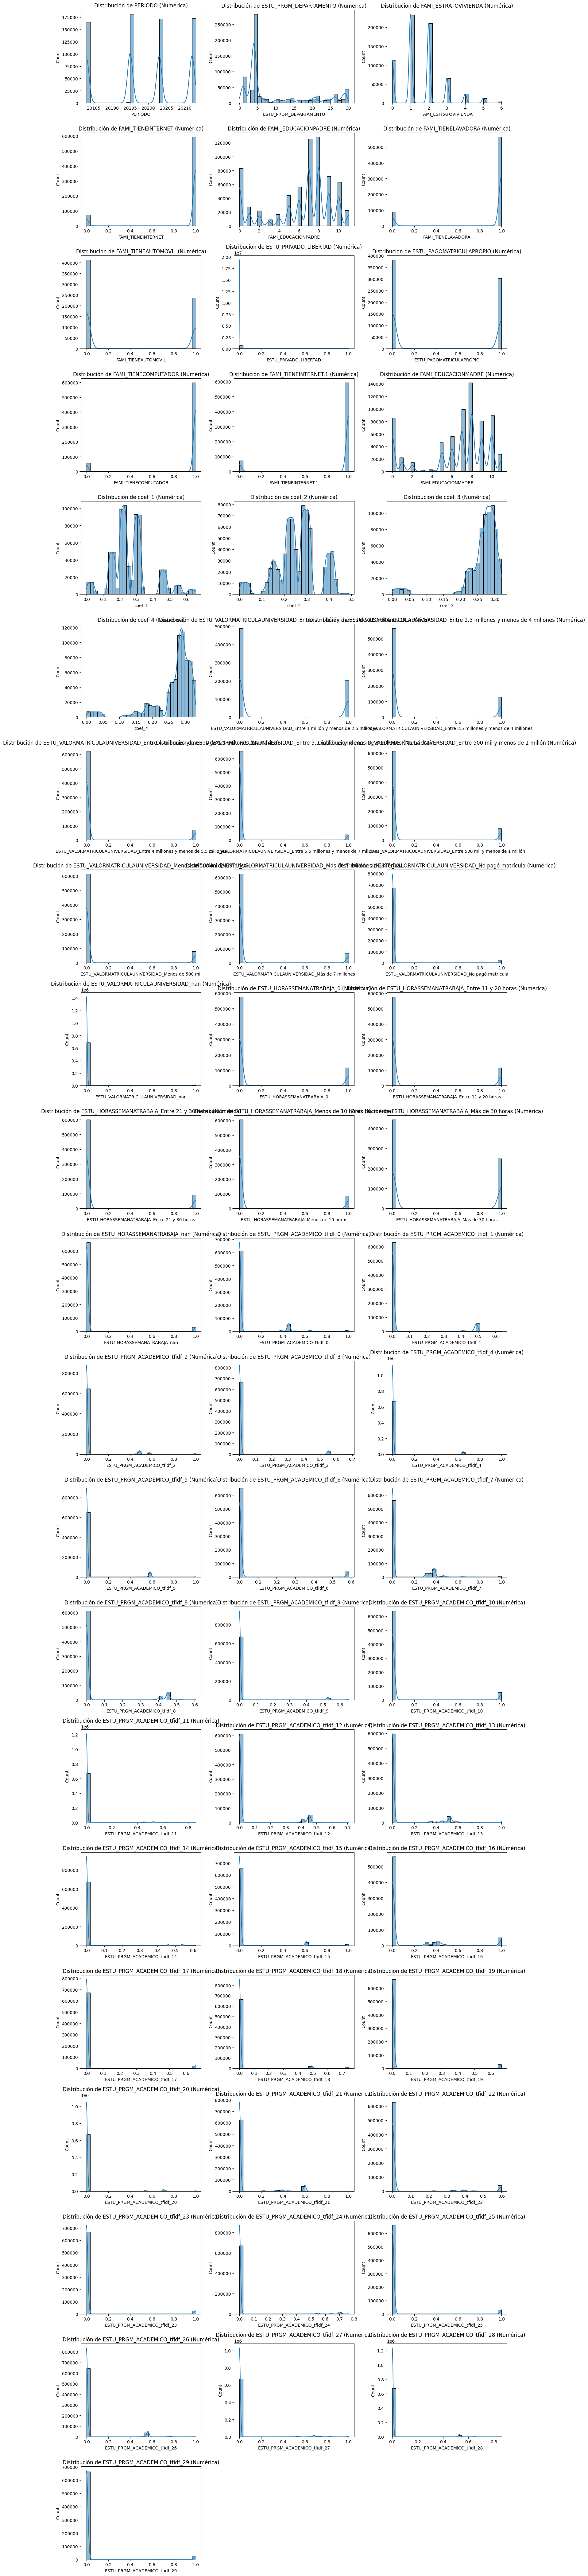


=== VISUALIZACIÓN DE DISTRIBUCIÓN COMPLETADA ===


In [16]:


import seaborn as sns
import matplotlib.pyplot as plt

print("\n=== VISUALIZACIÓN DE DISTRIBUCIÓN DE COLUMNAS CON SEABORN ===")

# Seleccionar un subconjunto de columnas para visualizar para no saturar
# Puedes ajustar este número según la cantidad total de columnas
cols_to_visualize = df_final.columns.tolist()

# Excluir columnas de texto libre normalizado si no fueron agrupadas, ya que HashingVectorizer las manejará
cols_to_visualize = [col for col in cols_to_visualize if not (col.endswith('_normalizado') and col not in nominal_cols)]
cols_to_visualize = [col for col in cols_to_visualize if col != TARGET_COL] # Excluir la columna original si ya creamos una limpia/final

print(f"Visualizando la distribución de {len(cols_to_visualize)} columnas...")

# Definir un número de columnas por fila para los subplots
n_cols_subplot = 3
n_rows_subplot = (len(cols_to_visualize) + n_cols_subplot - 1) // n_cols_subplot

# Ajustar el tamaño de la figura
plt.figure(figsize=(n_cols_subplot * 5, n_rows_subplot * 4))

for i, col in enumerate(cols_to_visualize):
    plt.subplot(n_rows_subplot, n_cols_subplot, i + 1)

    # Usar seaborn para visualizar la distribución
    if pd.api.types.is_numeric_dtype(df_final[col]):
        # Histograma para columnas numéricas
        sns.histplot(data=df_final, x=col, kde=True, bins=30)
        plt.title(f'Distribución de {col} (Numérica)')
    else:
        # Conteo de barras para columnas categóricas
        # Limitar a los top 10-15 valores para columnas con alta cardinalidad agrupada
        if df_final[col].nunique() > 15:
            top_values = df_final[col].value_counts().nlargest(15).index
            sns.countplot(data=df_final[df_final[col].isin(top_values)], y=col, order=top_values)
            plt.title(f'Top 15 Distribución de {col}')
        else:
            sns.countplot(data=df_final, y=col, order=df_final[col].value_counts().index)
            plt.title(f'Distribución de {col}')
        plt.ylabel('') # Eliminar la etiqueta del eje y para que no se solape

    plt.tight_layout()

plt.show()

print("\n=== VISUALIZACIÓN DE DISTRIBUCIÓN COMPLETADA ===")


In [18]:
pd.set_option('display.max_columns', None)
df_final.head()

,PERIODO,ESTU_PRGM_DEPARTAMENTO,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_TIENEINTERNET.1,FAMI_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,coef_1,coef_2,coef_3,coef_4,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 1 millón y menos de 2.5 millones,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 2.5 millones y menos de 4 millones,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 4 millones y menos de 5.5 millones,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 5.5 millones y menos de 7 millones,ESTU_VALORMATRICULAUNIVERSIDAD_Entre 500 mil y menos de 1 millón,ESTU_VALORMATRICULAUNIVERSIDAD_Menos de 500 mil,ESTU_VALORMATRICULAUNIVERSIDAD_Más de 7 millones,ESTU_VALORMATRICULAUNIVERSIDAD_No pagó matrícula,ESTU_VALORMATRICULAUNIVERSIDAD_nan,ESTU_HORASSEMANATRABAJA_0,ESTU_HORASSEMANATRABAJA_Entre 11 y 20 horas,ESTU_HORASSEMANATRABAJA_Entre 21 y 30 horas,ESTU_HORASSEMANATRABAJA_Menos de 10 horas,ESTU_HORASSEMANATRABAJA_Más de 30 horas,ESTU_HORASSEMANATRABAJA_nan,ESTU_PRGM_ACADEMICO_tfidf_0,ESTU_PRGM_ACADEMICO_tfidf_1,ESTU_PRGM_ACADEMICO_tfidf_2,ESTU_PRGM_ACADEMICO_tfidf_3,ESTU_PRGM_ACADEMICO_tfidf_4,ESTU_PRGM_ACADEMICO_tfidf_5,ESTU_PRGM_ACADEMICO_tfidf_6,ESTU_PRGM_ACADEMICO_tfidf_7,ESTU_PRGM_ACADEMICO_tfidf_8,ESTU_PRGM_ACADEMICO_tfidf_9,ESTU_PRGM_ACADEMICO_tfidf_10,ESTU_PRGM_ACADEMICO_tfidf_11,ESTU_PRGM_ACADEMICO_tfidf_12,ESTU_PRGM_ACADEMICO_tfidf_13,ESTU_PRGM_ACADEMICO_tfidf_14,ESTU_PRGM_ACADEMICO_tfidf_15,ESTU_PRGM_ACADEMICO_tfidf_16,ESTU_PRGM_ACADEMICO_tfidf_17,ESTU_PRGM_ACADEMICO_tfidf_18,ESTU_PRGM_ACADEMICO_tfidf_19,ESTU_PRGM_ACADEMICO_tfidf_20,ESTU_PRGM_ACADEMICO_tfidf_21,ESTU_PRGM_ACADEMICO_tfidf_22,ESTU_PRGM_ACADEMICO_tfidf_23,ESTU_PRGM_ACADEMICO_tfidf_24,ESTU_PRGM_ACADEMICO_tfidf_25,ESTU_PRGM_ACADEMICO_tfidf_26,ESTU_PRGM_ACADEMICO_tfidf_27,ESTU_PRGM_ACADEMICO_tfidf_28,ESTU_PRGM_ACADEMICO_tfidf_29
0,20212,4,2.0,1.0,11.0,1.0,1.0,0,0.0,1.0,1.0,5.0,2,0.322,0.208,0.310,0.267,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20212,3,2.0,0.0,10.0,1.0,0.0,0,0.0,1.0,0.0,11.0,0,0.311,0.215,0.292,0.264,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20203,4,2.0,1.0,8.0,1.0,0.0,0,0.0,0.0,1.0,8.0,0,0.297,0.214,0.305,0.264,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20195,26,3.0,1.0,4.0,1.0,0.0,0,0.0,1.0,1.0,8.0,3,0.485,0.172,0.252,0.190,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,0.451349,0.489406,0.0,0.0,0.0,0.0,0.0,0.383902,0.452438,0.0,0.0,0.0,0.452421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20212,1,2.0,1.0,6.0,1.0,1.0,0,0.0,1.0,1.0,6.0,1,0.316,0.232,0.285,0.294,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
df_final.info()

Nos dimos cuenta que aún quedan valores por rellenas, en este caso optamos por crear una función que los rellene de manera aleatoria

In [19]:
def imputar_valores_aleatorios(df):
    df_imputado = df.copy()

    for columna in df.columns:
        if df[columna].isnull().any():
            valores_validos = df[columna].dropna().values
            if len(valores_validos) > 0:
                valores_imputados = np.random.choice(valores_validos, size=df[columna].isnull().sum(), replace=True)
                df_imputado.loc[df[columna].isnull(), columna] = valores_imputados
            else:
                print(f"La columna '{columna}' no tiene valores válidos para imputar.")

    return df_imputado

In [22]:
# Identificar las columnas con datos faltantes (basado en tu output)
missing_cols_list = [
    'FAMI_ESTRATOVIVIENDA',
    'FAMI_TIENEINTERNET',
    'FAMI_EDUCACIONPADRE',
    'FAMI_TIENELAVADORA',
    'FAMI_TIENEAUTOMOVIL',
    'ESTU_PAGOMATRICULAPROPIO',
    'FAMI_TIENECOMPUTADOR',
    'FAMI_TIENEINTERNET.1',
    'FAMI_EDUCACIONMADRE'
]

# Asegurarse de que solo intentamos rellenar columnas que existen en df_final
missing_cols_in_df_final = [col for col in missing_cols_list if col in df_final.columns]

# Aplicar la función al dataset final numérico
df_final_filled = imputar_valores_aleatorios(df_final)

# Verificar si todavía hay valores faltantes
print("\nVerificando valores faltantes después de rellenar:")
valores_faltantes_after = df_final_filled.isnull().sum()
if valores_faltantes_after.sum() > 0:
    print(valores_faltantes_after[valores_faltantes_after > 0])
else:
    print("✓ No hay valores faltantes después del rellenado aleatorio.")

# Mostrar las primeras filas del DataFrame con datos rellenados
print("\nPrimeras 5 filas del dataset después de rellenar:")
print(df_final_filled.head())


Verificando valores faltantes después de rellenar:
✓ No hay valores faltantes después del rellenado aleatorio.

Primeras 5 filas del dataset después de rellenar:
   PERIODO  ESTU_PRGM_DEPARTAMENTO  FAMI_ESTRATOVIVIENDA  FAMI_TIENEINTERNET  \
0    20212                       4                   2.0                 1.0   
1    20212                       3                   2.0                 0.0   
2    20203                       4                   2.0                 1.0   
3    20195                      26                   3.0                 1.0   
4    20212                       1                   2.0                 1.0   

   FAMI_EDUCACIONPADRE  FAMI_TIENELAVADORA  FAMI_TIENEAUTOMOVIL  \
0                 11.0                 1.0                  1.0   
1                 10.0                 1.0                  0.0   
2                  8.0                 1.0                  0.0   
3                  4.0                 1.0                  0.0   
4                  6.

In [24]:
df_final_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692500 entries, 0 to 692499
Data columns (total 62 columns):
 #   Column                                                                   Non-Null Count   Dtype  
---  ------                                                                   --------------   -----  
 0   PERIODO                                                                  692500 non-null  int64  
 1   ESTU_PRGM_DEPARTAMENTO                                                   692500 non-null  int64  
 2   FAMI_ESTRATOVIVIENDA                                                     692500 non-null  float64
 3   FAMI_TIENEINTERNET                                                       692500 non-null  float64
 4   FAMI_EDUCACIONPADRE                                                      692500 non-null  float64
 5   FAMI_TIENELAVADORA                                                       692500 non-null  float64
 6   FAMI_TIENEAUTOMOVIL                                         

Además identificamos una columna repetida ['FAMI_TIENEINTERNET.1'] que basicamente eliminaremos, cuando vayamos a comparar los modelos.

# Hasta acá es la entrega 2